<a href="https://colab.research.google.com/github/aovaldes2/-Data-Science-Portfolio/blob/main/New_York_City_Taxi_Trip_Duration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and importing dependencies

In [ ]:
  #dependency installs
  !pip install kaggle
  !pip install haversine

In [ ]:
# import dependencies
import numpy as np 
import pandas as pd
import io
import time
import math
import haversine as hs
from scipy import stats
from datetime import date

# for visualization
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
%matplotlib inline
# to include graphs inline within the frontends next to code
import seaborn as sns


# machine learning models
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

# preprocessing functions and evaluation models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans

# settings
import warnings
warnings.filterwarnings("ignore")

# Google drive conection

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Checking MyDrive Folder

In [ ]:
import os.path
from os import path

if path.exists('/content/gdrive/MyDrive/New York City Taxi Trip Duration') == False:
  os.mkdir('/content/gdrive/MyDrive/New York City Taxi Trip Duration')

os.chdir('/content/gdrive/MyDrive/New York City Taxi Trip Duration')
!pwd
!ls

/content/gdrive/MyDrive/New York City Taxi Trip Duration
kaggle.json	       sample_submission.zip  test.zip	 train.zip
sample_submission.csv  test.csv		      train.csv


## Upload  the kaggle credentials(Needed only the first time)

In [ ]:
#upload  the kaggle credentials
#https://github.com/Kaggle/kaggle-api
if path.exists('/content/gdrive/MyDrive/New York City Taxi Trip Duration/kaggle.json') == False:
  from google.colab import files
  files.upload()

%ls

kaggle.json            sample_submission.zip  test.zip   train.zip
sample_submission.csv  test.csv               train.csv


# Download the dataset from Kaggle

In [ ]:
#Download the dataset
Subpath = '/content/gdrive/MyDrive/New York City Taxi Trip Duration/'


if path.exists(Subpath+'sample_submission.zip') == False:
  !kaggle competitions download -c nyc-taxi-trip-duration



#Unzip Data
Subpath = '/content/gdrive/MyDrive/New York City Taxi Trip Duration/'
if path.exists(Subpath+'test.csv') == False:
  !unzip test.zip
if path.exists(Subpath+'train.csv') == False:  
  !unzip train.zip
if path.exists(Subpath+'sample_submission.csv') == False:
  !unzip sample_submission.zip


# Defining the datasets

In [ ]:
df_train = pd.read_csv(Subpath+'train.csv')
df_test = pd.read_csv(Subpath+'test.csv')
sample_submission= pd.read_csv(Subpath+'sample_submission.csv')



### Useful functions



In [ ]:
# function to train a given model, generate predictions, and return accuracy score
def fit_evaluate_model(model, X_train, y_train, X_valid, Y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return accuracy_score(y_valid, y_predicted)

In [ ]:
def unistats(df):
    import pandas as pd
    output_df = pd.DataFrame(columns=['Count','Missing','Unique','Dtype','Numeric','Mode','Mean','Min','25%','Median','75%','Max','Std','Skew','Kurt'])
    for col in df:
        if pd.api.types.is_numeric_dtype(df[col]) and df[col].dtype !='bool' and pd.isnull(df[col]).all()!=True:
            
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                                  df[col].mode().values[0], df[col].mean(),df[col].min(), df[col].quantile(0.25), df[col].median(),
                                  df[col].quantile(0.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt()]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                                   '-' if pd.isnull(df[col]).all() else df[col].mode().values[0],'-','-','-','-','-','-','-','-','-']
    return output_df.sort_values(by=['Numeric', 'Skew','Unique'],ascending=False)

Function for selecting the bounding box [BB]

In [ ]:
def select_within_boundingbox(df, BB):
    return ((df["pickup_longitude"] >= BB[0]) & (df["pickup_longitude"] <= BB[1]) & 
            (df["pickup_latitude"] >= BB[2]) & (df["pickup_latitude"] <= BB[3]) &
            (df["dropoff_longitude"] >= BB[0]) & (df["dropoff_longitude"] <= BB[1]) &
            (df["dropoff_latitude"] >= BB[2]) & (df["dropoff_latitude"] <= BB[3]))

# **Exploratory Data Analysis**

### Basics

In [ ]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


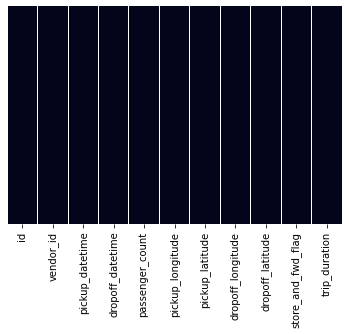

In [ ]:
#No missing values
import seaborn as sns
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False);

There are no null values in this dataset which saves us a step of imputing.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


### Data Fields 


***id*** - a unique identifier for each trip

***vendor_id*** - a code indicating the provider associated with the trip record

***pickup_datetime*** - date and time when the meter was engaged

***dropoff_datetime*** - date and time when the meter was disengaged

***passenger_count*** - the number of passengers in the vehicle (driver entered value)

***pickup_longitude*** - the longitude where the meter was engaged

***pickup_latitude*** - the latitude where the meter was engaged

***dropoff_longitude*** - the longitude where the meter was disengaged

***dropoff_latitude*** - the latitude where the meter was disengaged

***store_and_fwd_flag*** - This flag indicates whether the trip record was held in 
vehicle memory before sending to the vendor because the vehicle did not have a 

***connection to the server :*** 
*   Y=store and forward
*   N=not a store and forward trip



***trip_duration*** - duration of the trip in seconds


***Disclaimer:*** The decision was made to not remove dropoff coordinates from the dataset order to provide an expanded set of variables to use in Kernels.




#### Univariate statistics

In [ ]:
unistats(df_train)

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
trip_duration,1458644,0,7417,int64,True,368,959.492273,1,397.0,662.0,1075.0,3526282,5237.431724,343.163944,192131.517307
pickup_latitude,1458644,0,45245,float64,True,40.774101,40.750921,34.359695,40.737347,40.754101,40.76836,51.881084,0.032881,5.489127,12950.241541
passenger_count,1458644,0,10,int64,True,1,1.66453,0,1.0,1.0,2.0,9,1.314242,2.128094,3.431771
vendor_id,1458644,0,2,int64,True,2,1.53495,1,1.0,2.0,2.0,2,0.498777,-0.140144,-1.980362
dropoff_latitude,1458644,0,62519,float64,True,40.774311,40.7518,32.181141,40.735885,40.754524,40.76981,43.921028,0.035891,-20.671187,4259.542553
pickup_longitude,1458644,0,23047,float64,True,-73.982201,-73.973486,-121.933342,-73.991867,-73.981743,-73.967331,-61.335529,0.070902,-418.120385,288156.52038
dropoff_longitude,1458644,0,33821,float64,True,-73.98233,-73.973416,-121.933304,-73.991325,-73.979752,-73.963013,-61.335529,0.070643,-425.331724,292526.021772
id,1458644,0,1458644,object,False,id0000001,-,-,-,-,-,-,-,-,-
dropoff_datetime,1458644,0,1380377,object,False,2016-02-19 19:25:04,-,-,-,-,-,-,-,-,-
pickup_datetime,1458644,0,1380222,object,False,2016-01-12 18:48:44,-,-,-,-,-,-,-,-,-


### Summary so far(understanding the data):



* Train dataset has 1458644 rows and 11 columns.
* There are 2 unique vendor ids.
* There are 10 unique passenger counts.
* There are 2 unique values for store_and_fwd_flag, that we also saw in the description of the variables, which are Y and N.
 
* There are no NA in the dataset.

* Passenger count has a minimum of 0 which means either it is an error entered or the drivers deliberately entered 0 to complete a target number of rides.

## **Feature Creation**

## Engineering necessary for the model

Let us create some new features from the existing variables so that we can gain more insights from the data

In [ ]:
df_test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

### **Datetime features**

In [ ]:

df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_train['dropoff_datetime']=pd.to_datetime(df_train['dropoff_datetime'])
df_train['pickup_day']=df_train['pickup_datetime'].dt.day_name()
df_train['dropoff_day']=df_train['dropoff_datetime'].dt.day_name()
df_train['pickup_day_no']=df_train['pickup_datetime'].dt.weekday
df_train['dropoff_day_no']=df_train['dropoff_datetime'].dt.weekday
df_train['pickup_minute'] = df_train['pickup_datetime'].dt.minute
df_train['dropoff_minute'] = df_train['dropoff_datetime'].dt.minute
df_train['pickup_hour']=df_train['pickup_datetime'].dt.hour
df_train['pickup_week_hour'] = df_train['pickup_day_no'] * 24 + df_train['pickup_hour']
df_train['dropoff_hour']=df_train['dropoff_datetime'].dt.hour
df_train['pickup_month']=df_train['pickup_datetime'].dt.month
df_train['dropoff_month']=df_train['dropoff_datetime'].dt.month
df_train['check_trip_duration'] = (df_train['dropoff_datetime'] - df_train['pickup_datetime']).map(lambda x: x.total_seconds())



df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
df_test['pickup_hour']=df_test['pickup_datetime'].dt.hour
df_test['pickup_day_no']=df_test['pickup_datetime'].dt.weekday
df_test['pickup_week_hour'] = df_test['pickup_day_no'] * 24 + df_test['pickup_hour']
df_test['pickup_month']=df_test['pickup_datetime'].dt.month
df_test['pickup_day']=df_test['pickup_datetime'].dt.day_name()
df_test['pickup_minute'] = df_test['pickup_datetime'].dt.minute

duration_difference = df_train[np.abs(df_train['check_trip_duration'].values  - df_train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


We have created the following features:

* pickup_day and dropoff_day which will contain the name of the day on which the ride was taken.
* pickup_day_no and dropoff_day_no which will contain the day number instead of characters with Monday=0 and Sunday=6.
* pickup_hour and dropoff_hour with an hour of the day in the 24-hour format.
* pickup_month and dropoff_month with month number with January=1 and December=12

### **Distance**

Euclidean Distance works for the flat surface like a Cartesian plain however, Earth is not flat. So we have to use a special type of formula known as Haversine Distance.

Haversine Distance can be defined as the angular distance between two locations on the Earth’s surface.

Haversine distance can be calculated as:

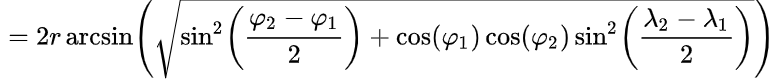


In [ ]:

def cal_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return hs.haversine(start_coordinates,stop_coordinates)

In [ ]:
def dummy_distance(lat1, lng1, lat2, lng2):
    c1 = cal_distance(lat1, lng1, lat1, lng2)
    c2 = cal_distance(lat1, lng1, lat2, lng1)
    return c1 + c2


In [ ]:
df_train['distance'] = df_train.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

In [ ]:
df_test['distance'] = df_test.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']),axis = 1)

In [ ]:
df_train['dummy_distance'] = df_train.apply(lambda x: dummy_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

In [ ]:
df_test['dummy_distance'] = df_test.apply(lambda x: dummy_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']),axis = 1)

In [ ]:
df_train['distance'].value_counts()

0.000000    5897
0.000424     101
0.000424      52
0.000424      48
0.000848      37
            ... 
2.988820       1
3.134769       1
3.231345       1
1.584861       1
1.134044       1
Name: distance, Length: 1452288, dtype: int64

There are 5897 trips with 0 km distance.

The reasons for 0 km distance can be:

* The dropoff location couldn’t be tracked.
* The driver deliberately took this ride to complete a target ride number.
* The passengers canceled the trip.

### **Speed**

In [ ]:
df_train['avg_speed_h'] = 1000 * df_train['distance'] / df_train['trip_duration']
df_train['avg_speed_d'] = 1000 * df_train['dummy_distance'] / df_train['trip_duration']

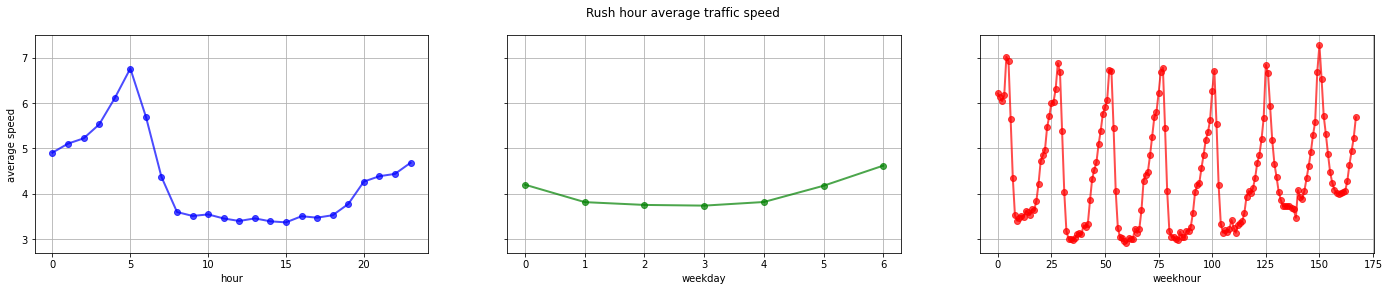

In [ ]:
plt.rcParams["figure.figsize"] = (24,4)
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(df_train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(df_train.groupby('dropoff_day_no').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(df_train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
#ax[0].set_xticks(np.arange())
fig.suptitle('Rush hour average traffic speed')
plt.show()
plt.rcParams['axes.grid'] = plt.rcParamsDefault["axes.grid"]
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

It seems that every day around 5 am the taxis move faster than the rest of the day it's logical because in those hours there is less traffic 

### **Trip duration(Target)**

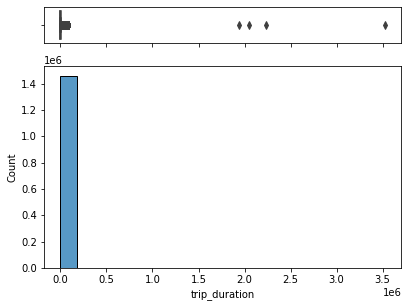

In [ ]:

# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(df_train['trip_duration'], ax=ax_box)
sns.histplot(data=df_train, x="trip_duration",kde=False,bins=20, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

The histogram is really skewed as we can see. We can clearly see outlier's, because we dont want to loose data lets apply a tramformation of the variable. Fortunately the evaluation metric is RMSLE and not RMSE. Outliers will cause less trouble. We could logtransform our target label and use RMSE during training.

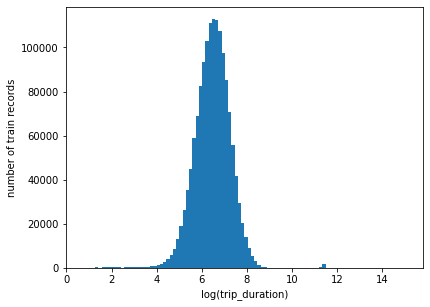

In [ ]:
df_train['log_trip_duration'] = np.log(df_train['trip_duration'].values + 1)
plt.hist(df_train['log_trip_duration'], bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

Vendor_id

### **Store and Forward Flag**

In [ ]:
df_train['store_and_fwd_flag'].value_counts(normalize=True)

N    0.994485
Y    0.005515
Name: store_and_fwd_flag, dtype: float64

 There are less than 1% of trips that were stored before forwarding.

In [ ]:
# transform character to numeric
le = LabelEncoder()
le.fit(df_train['store_and_fwd_flag'])
df_train['store_and_fwd_flag'] = le.transform(df_train['store_and_fwd_flag'])
df_test['store_and_fwd_flag'] = le.transform(df_test['store_and_fwd_flag'])

### **Direction**

In [ ]:
df_train["delta_lon"] = df_train["pickup_longitude"] - df_train["dropoff_longitude"]
df_train["delta_lat"] = df_train["pickup_latitude"] - df_train["dropoff_latitude"]

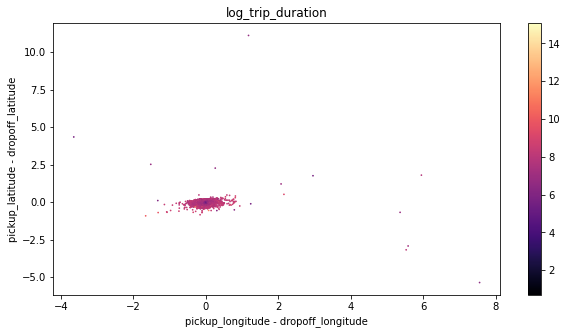

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(df_train["delta_lon"], df_train["delta_lat"], s=0.5, alpha=1.0,
            c=df_train["log_trip_duration"], cmap="magma")
plt.colorbar()
plt.xlabel('pickup_longitude - dropoff_longitude')
plt.ylabel('pickup_latitude - dropoff_latitude')
plt.title('log_trip_duration');

It seems really scattered values ​​of some differences. We are going to approach where the majority of values ​​are, in this case Manhattan.

In [ ]:
BB_manhattan = (-74.025, -73.925, 40.7, 40.8)
idx_manhattan = select_within_boundingbox(df_train, BB_manhattan)

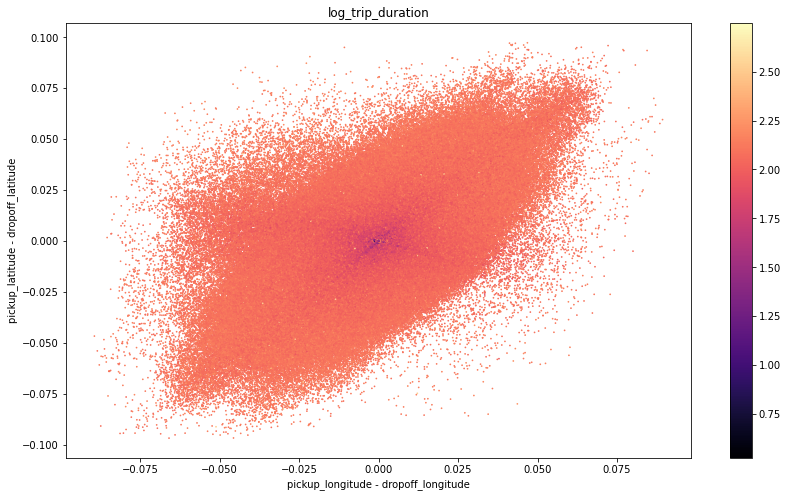

In [ ]:
plt.figure(figsize=(14,8))
plt.scatter(df_train[idx_manhattan]["delta_lon"], df_train[idx_manhattan]["delta_lat"], s=0.5, alpha=1.0,
            c=np.log1p(df_train[idx_manhattan]["log_trip_duration"]), cmap="magma")
plt.colorbar()
plt.xlabel('pickup_longitude - dropoff_longitude')
plt.ylabel('pickup_latitude - dropoff_latitude')
plt.title('log_trip_duration');

Looks like direction of the trip seems to matter. Direction of a trip, from 180 to -180 degrees. Horizontal axes = 0 degrees

Bearing measures the direction of travel 

The formula is: θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ ) where λ is the longitude

In [ ]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [ ]:
df_train['direction'] = bearing_array(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)
df_test['direction'] = bearing_array(df_test['pickup_latitude'].values, df_test['pickup_longitude'].values, df_test['dropoff_latitude'].values, df_test['dropoff_longitude'].values)

### **Clustering**

Besides of keeping entire list of latitude and longitute, the data will be grouped by some approximate locations. It might be helpful for the xgboost since it will take 4 branches of tree (It will use a tree-based algorithm) to specify a square region. 
Note that the resulting feature is categorical value between 0,1,2,…,9. To use this feature in xgboost, you can to transform it to 20 dummy variables, otherwise the module will treat it as numerical.

In [ ]:
coords = np.vstack((df_train[['pickup_latitude', 'pickup_longitude']].values,
                    df_train[['dropoff_latitude', 'dropoff_longitude']].values,
                    df_test[['pickup_latitude', 'pickup_longitude']].values,
                    df_test[['dropoff_latitude', 'dropoff_longitude']].values))

coords        

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ...,
       [ 40.74866486, -73.87660217],
       [ 40.89178848, -73.85426331],
       [ 40.76937866, -73.96932983]])

In [ ]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10000).fit(coords[sample_ind])

In [ ]:
df_train['pickup_cluster'] = kmeans.predict(df_train[['pickup_latitude', 'pickup_longitude']])
df_train['dropoff_cluster'] = kmeans.predict(df_train[['dropoff_latitude', 'dropoff_longitude']])
df_test['pickup_cluster'] = kmeans.predict(df_test[['pickup_latitude', 'pickup_longitude']])
df_test['dropoff_cluster'] = kmeans.predict(df_test[['dropoff_latitude', 'dropoff_longitude']])

Text(0.5, 1.0, 'Dropoff')

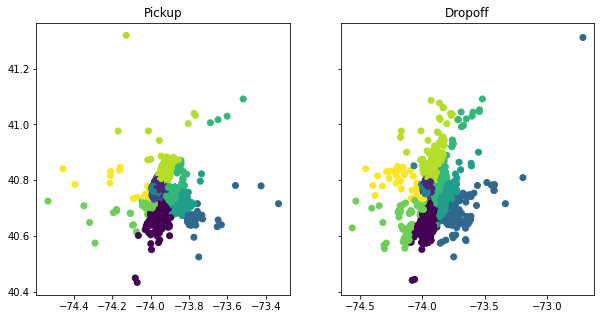

In [ ]:
n = 100000 # Number of data points to plot
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(df_train.pickup_longitude[:n], 
            df_train.pickup_latitude[:n],
            cmap = 'viridis',
            c = df_train.pickup_cluster[:n])
ax1.set_title('Pickup')
ax2.scatter(df_train.dropoff_longitude[:n], 
            df_train.dropoff_latitude[:n],
            cmap = 'viridis',
            c = df_train.dropoff_cluster[:n])
ax2.set_title('Dropoff')

## Unnecessary for the model

### **Longitude and Latitud graphics**

**Here, we will try to define bounding box of interest by [long_min, long_max, latt_min, latt_max] using the minimum and maximum coordinates from test.csv.**

This will help us to make sure to train a model for the full pickup/dropoff co-ordinate range for the test set.

Minimum and Maximum Longitude Test set

In [ ]:
print(min(df_test["pickup_longitude"].min(), df_test["dropoff_longitude"].min()))
print(max(df_test["pickup_longitude"].max(), df_test["dropoff_longitude"].max()))
print(min(df_train["pickup_longitude"].min(), df_train["dropoff_longitude"].min()))
print(max(df_train["pickup_longitude"].max(), df_train["dropoff_longitude"].max()))

-121.9333267211914
-67.49679565429688
-121.93334197998048
-61.33552932739258


Minimum and Maximum Latutude Test Set


In [ ]:
print(min(df_test["pickup_latitude"].min(), df_test["dropoff_latitude"].min()))
print(max(df_test["pickup_latitude"].max(), df_test["dropoff_latitude"].max()))
print(min(df_train["pickup_latitude"].min(), df_train["dropoff_latitude"].min()))
print(max(df_train["pickup_latitude"].max(), df_train["dropoff_latitude"].max()))

36.601322174072266
48.85759735107422
32.1811408996582
51.88108444213867


We have a map with 74.5_-72.8_40.5_41.8 dimentions

In [ ]:
#To use unverified ssl i nedd to add this to the code:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

In [ ]:
BB = (-74.3, -73.0, 40.6, 41.7)
df_train_tomap = df_train[select_within_boundingbox(df_train, BB)]
print("Old size {}".format(len(df_train)))
print("New size {}".format(len(df_train_tomap)))

Old size 1458646
New size 1457331


Most of the data its the new Dataframe

In [ ]:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1,2,figsize=(16, 10))
    axs[0].scatter(df["pickup_longitude"], df["pickup_latitude"], alpha = alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup Locations')
    axs[0].imshow(nyc_map, extent=BB)
    
    axs[1].scatter(df["dropoff_longitude"], df["dropoff_latitude"] , alpha = alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff Locations')
    axs[1].imshow(nyc_map, extent=BB)

**Plotting Training Data on map**

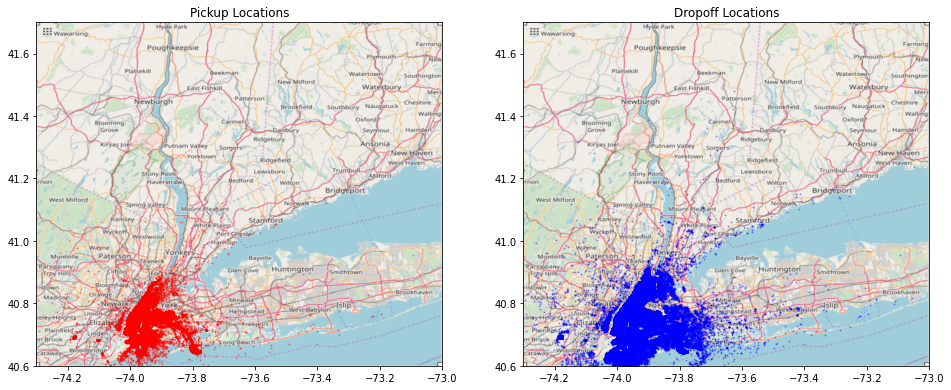

In [ ]:
plot_on_map(df_train_tomap, BB, nyc_map, s=1, alpha=0.3)

**Plotting testing Data on Map**

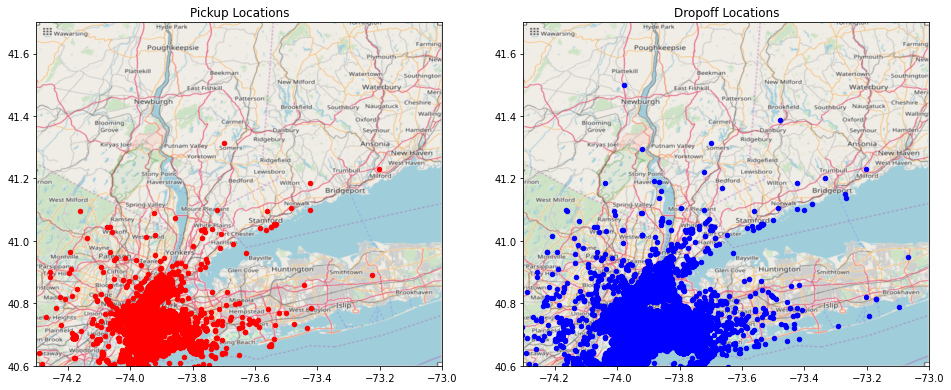

In [ ]:
plot_on_map(df_test, BB, nyc_map, alpha=1.0, s=20)  

### **Vendor Id**

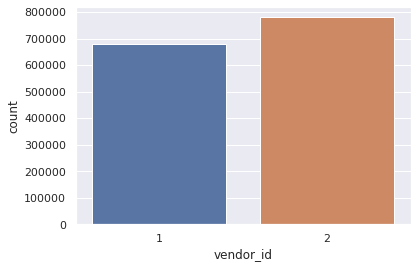

In [ ]:
sns.countplot(x='vendor_id',data=df_train);

There is not much difference between the trips taken by both vendors.

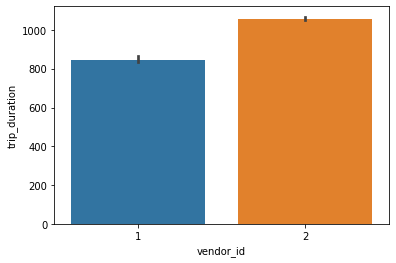

In [ ]:
sns.barplot(y='trip_duration',x='vendor_id',data=df_train,estimator=np.mean)

Vendor id 2 takes longer trips as compared to vendor 1.



###**Passenger Count**

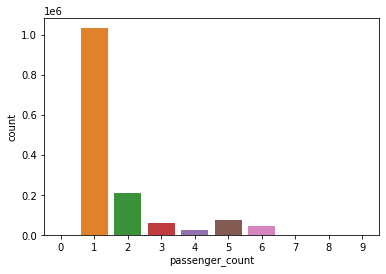

In [ ]:
df_train.passenger_count.value_counts()
sns.countplot(x='passenger_count',data=df_train);



* There are some trips with even 0 passenger count.
* There is only 1 trip each for 7 and 9 passengers.
* The highest amount of trips are with 1 passenger.



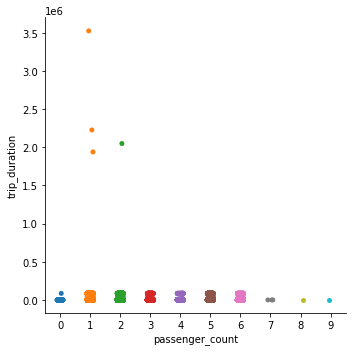

In [ ]:
sns.catplot(y='trip_duration',x='passenger_count',data=df_train,kind='strip');

There is no visible relation between trip duration and passenger count.

###**Trips per Day**

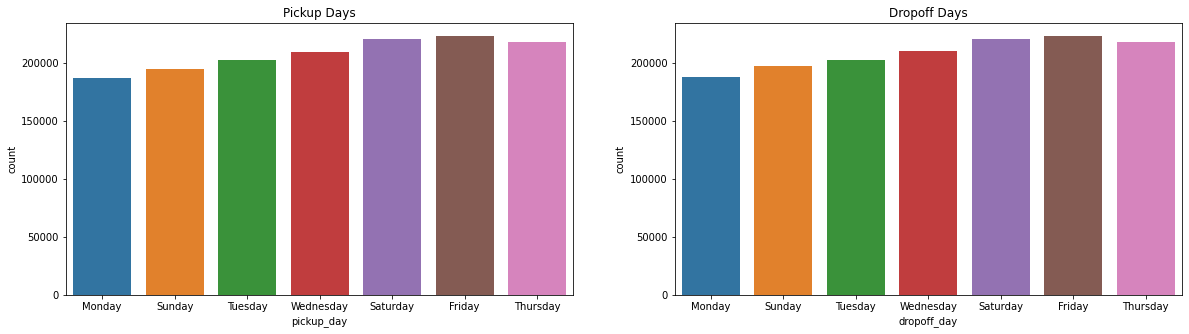

In [ ]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Days')
ax=sns.countplot(x="pickup_day",data=df_train,ax=ax1)
ax2.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_day",data=df_train,ax=ax2)

 Fridays are the busiest days followed by Saturdays. That is probably because it’s weekend.

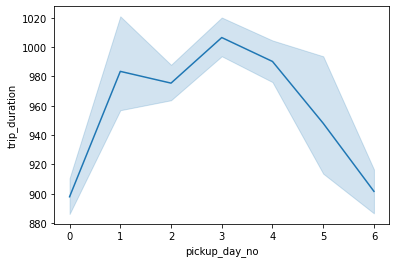

In [ ]:
sns.lineplot(x='pickup_day_no',y='trip_duration',data=df_train);

Trip duration is the longest on Thursdays closely followed by Fridays.

### **Trips per Hour**

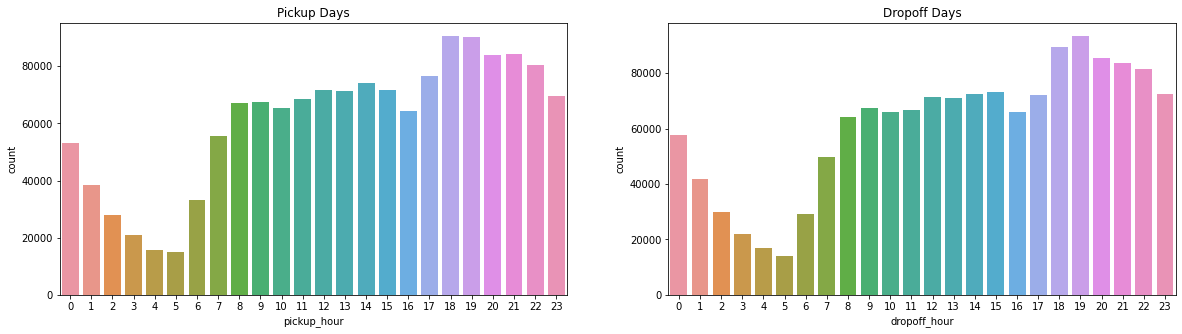

In [ ]:
figure,(ax9,ax10)=plt.subplots(ncols=2,figsize=(20,5))
ax9.set_title('Pickup Days')
ax=sns.countplot(x="pickup_hour",data=df_train,ax=ax9)
ax10.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_hour",data=df_train,ax=ax10)

The busiest hours are 6:00 pm to 7:00 pm and that makes sense as this is the time when people return from their offices.

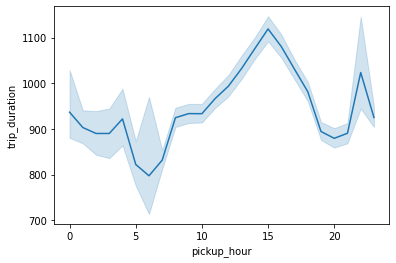

In [ ]:
sns.lineplot(x='pickup_hour',y='trip_duration',data=df_train);

The trip duration is the maximum around 3 pm which may be because of traffic on the roads.
Trip duration is the lowest around 6 am as streets may not be busy.

### **Trips per month**

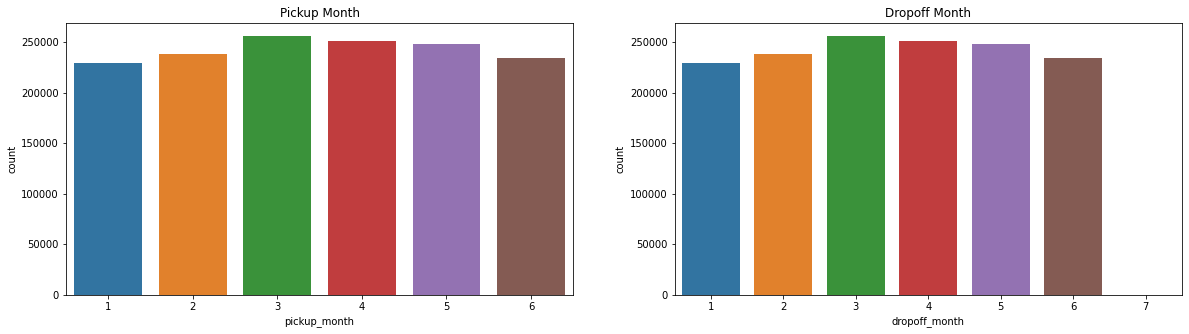

In [ ]:
figure,(ax11,ax12)=plt.subplots(ncols=2,figsize=(20,5))
ax11.set_title('Pickup Month')
ax=sns.countplot(x="pickup_month",data=df_train,ax=ax11)
ax12.set_title('Dropoff Month')
ax=sns.countplot(x="dropoff_month",data=df_train,ax=ax12)

There is not much difference in the number of trips across months.

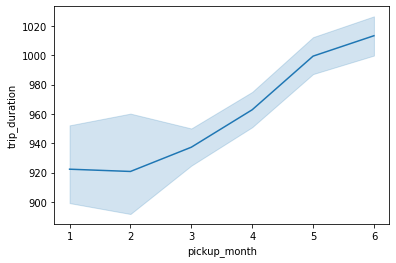

In [ ]:
sns.lineplot(x='pickup_month',y='trip_duration',data=df_train);

From February, we can see trip duration rising every month.

### **Trip Duration and Distance**

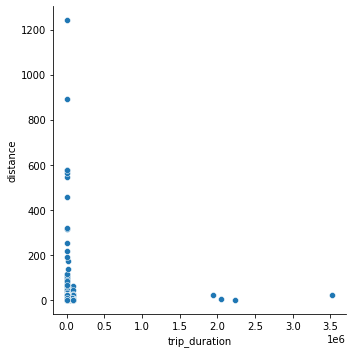

In [ ]:
sns.relplot(y=df_train.distance,x='trip_duration',data=df_train);

There are trips which trip duration as short as 0 seconds and yet covering a large distance. And, trips with 0 km distance and long trip durations.

In [ ]:
df_train[df_train['distance']== 0].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,pickup_day_no,dropoff_day_no,pickup_minute,dropoff_minute,pickup_hour,dropoff_hour,pickup_month,dropoff_month,check_trip_duration,distance,dummy_distance,avg_speed_h,avg_speed_d,log_trip_duration
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.981819,40.768963,-73.981819,40.768963,0,227,Monday,Monday,0,0,39,39,18,18,2,2,227.0,0.0,0.0,0.0,0.0,5.429346
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.959068,40.775661,-73.959068,40.775661,0,1109,Tuesday,Tuesday,1,1,7,7,18,18,5,5,1109.0,0.0,0.0,0.0,0.0,7.012115
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,0,947,Monday,Monday,0,0,15,15,23,23,5,5,947.0,0.0,0.0,0.0,0.0,6.854355
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.786720,40.647041,-73.786720,40.647041,0,580,Monday,Monday,0,0,45,45,19,19,1,1,580.0,0.0,0.0,0.0,0.0,6.364751
1620,id0753277,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.209854,40.816853,-74.209854,40.816853,0,27,Wednesday,Wednesday,2,2,29,29,22,22,1,1,27.0,0.0,0.0,0.0,0.0,3.332205


Even though distance is recorded as 0 but trip duration is definitely more.

* One reason can be that the dropoff coordinates weren’t recorded.
* Another reason one can think is that for short trip durations, maybe the passenger changed their mind and cancelled the ride after some time.


# **Addtional Dataset**

## OSMR features

We had only rough distance estimates in the previous versions. We will now use additional data extracted from OpenStreetMap which was used successfully in the top scores. Most of the high scores use [Data about Fastest Routes](https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm).  Travel distance should be more relevent here. The difficult part is to adquire this feature. Thanks to Oscarleo who manage to pull it off from OSRM.

### Load OSMR data


In [ ]:
# OSRM Dataset
fr1 = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/craftrip-594f5.appspot.com/o/fastest_routes_train_part_1.csv?alt=media&token=9b1832f8-2654-4835-9621-265e4f1f4c58', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps', ])
fr2 = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/craftrip-594f5.appspot.com/o/fastest_routes_train_part_2.csv?alt=media&token=26cc43e2-a68f-447c-9c9b-80255bb620d1', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/craftrip-594f5.appspot.com/o/fastest_routes_test.csv?alt=media&token=dd7ff2fe-ea90-46d9-8189-e0defbdf8955',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

#### Info

In [ ]:
fr1.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [ ]:
fr2.head()

,id,total_distance,total_travel_time,number_of_steps
0,id0363241,2603.4,211.8,4
1,id1188175,1526.9,195.0,5
2,id3584231,2564.9,341.0,8
3,id3283815,3886.2,331.9,7
4,id0420326,1706.4,235.7,4


In [ ]:
test_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id0771704,1497.1,200.2,7
1,id3274209,1427.1,141.5,2
2,id2756455,2312.3,324.6,9
3,id3684027,931.8,84.2,4
4,id3101285,2501.7,294.7,8


#### Concatenate all the data train data

In [ ]:
train_street_info = pd.concat((fr1, fr2))
train_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


On thing to be careful is that the data from Oscarleo has different order from the original data. Also sample size are different : len(df_train)=1458644;len(df_oscarleo)=1458643.

In [ ]:
df_train = df_train.merge(train_street_info, how='left', on='id')

In [ ]:
df_test = df_test.merge(test_street_info, how='left', on='id')

In [ ]:
df_test.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,pickup_day_no,pickup_week_hour,pickup_month,pickup_day,pickup_minute,distance,dummy_distance,direction,pickup_cluster,dropoff_cluster,total_distance,total_travel_time,number_of_steps
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,23,3,95,6,Thursday,59,2.746430,2.913308,-3.595224,2,2,3795.9,424.6,4
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,23,3,95,6,Thursday,59,2.759243,3.104809,172.278835,0,0,2904.5,200.0,4


## Weather features

This dataset([KNYC Metars 2016](https://www.kaggle.com/cabaki/knycmetars2016)) is ment to be used as a extra information for those willing to extract conclusions from their own dataset where hourly the weather information could be useful for their predictions / analysis. You can contact me if you have any doubt or suggestion. METAR is a format for reporting weather information. A METAR weather report is predominantly used by pilots in fulfillment of a part of a pre-flight weather briefing, and by meteorologists, who use aggregated METAR information to assist in weather forecasting.

In [ ]:
weather_data = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/pizzarush-40b2f.appspot.com/o/weather_data_nyc_centralpark_2016(1).csv?alt=media&token=a6fb7ce8-b4bc-4bc5-ac07-132a078bea85') # Replace with firebase link when available
weather_data.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0


In [ ]:
weather_data.dtypes

date                    object
maximum temperature      int64
minimum temperature      int64
average temperature    float64
precipitation           object
snow fall               object
snow depth              object
dtype: object

In [ ]:
unistats(weather_data)

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
minimum temperature,366,0,71,int64,True,40,49.806011,-1,37.25,48.0,65.0,81,16.570747,-0.16097,-0.782784
average temperature,366,0,122,float64,True,54.0,57.215847,7.0,44.0,55.75,73.5,88.5,17.12476,-0.18992,-0.883957
maximum temperature,366,0,71,int64,True,83,64.625683,15,50.0,64.5,81.0,96,18.041787,-0.213334,-0.962747
date,366,0,366,object,False,1-1-2016,-,-,-,-,-,-,-,-,-
precipitation,366,0,63,object,False,0,-,-,-,-,-,-,-,-,-
snow fall,366,0,11,object,False,0,-,-,-,-,-,-,-,-,-
snow depth,366,0,10,object,False,0,-,-,-,-,-,-,-,-,-


In [ ]:
weather_data.loc[weather_data['precipitation']== 'T', 'precipitation'] = '0.00'
weather_data['precipitation'] = (weather_data['precipitation']).astype(float)

weather_data.loc[weather_data['snow fall']== 'T', 'snow fall'] = '0.00'
weather_data['snow fall'] = (weather_data['snow fall']).astype(float)

weather_data.loc[weather_data['snow depth']== 'T', 'snow depth'] = '0.00'
weather_data['snow depth'] = (weather_data['snow depth']).astype(float)

In [ ]:
weather_data['date'] = pd.to_datetime(weather_data.date)
weather_data['weather_dayofyear']= weather_data.date.dt.dayofyear

In [ ]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,pickup_day_no,dropoff_day_no,pickup_minute,dropoff_minute,pickup_hour,pickup_week_hour,dropoff_hour,pickup_month,dropoff_month,check_trip_duration,distance,dummy_distance,avg_speed_h,avg_speed_d,log_trip_duration,delta_lon,delta_lat,direction,pickup_cluster,dropoff_cluster,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,Monday,Monday,0,0,24,32,17,17,17,3,3,455.0,1.498523,1.735436,3.293457,3.814144,6.122493,-0.017525,0.002335,99.970196,4,1,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,Sunday,Sunday,6,6,43,54,0,144,0,6,6,663.0,1.805510,2.430509,2.723242,3.665927,6.498282,0.019066,0.007412,-117.153768,2,9,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,Tuesday,Tuesday,1,1,35,10,11,35,12,1,1,2124.0,6.385107,8.203586,3.006171,3.862329,7.661527,0.026306,0.053852,-159.680165,4,7,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,Wednesday,Wednesday,2,2,32,39,19,67,19,4,4,429.0,1.485500,1.661334,3.462705,3.872572,6.063785,0.002228,0.013252,-172.737700,7,7,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,Saturday,Saturday,5,5,30,38,13,133,13,3,3,435.0,1.188590,1.199458,2.732391,2.757376,6.077642,-0.000130,0.010689,179.473585,1,1,1614.9,140.1,5.0


In [ ]:
# Merge train dataset with the weather dataset through date column
weather = weather_data[['date','minimum temperature', 'precipitation', 'snow fall', 'snow depth']]

df_train['date'] = df_train['pickup_datetime'].dt.date
df_train['date'] = pd.to_datetime(df_train['date'])
df_train= df_train.merge(weather, how='left', left_on='date', right_on='date')

In [ ]:
# Merge test dataset with the weather dataset through date column

df_test['date'] = df_test['pickup_datetime'].dt.date
df_test['date'] = pd.to_datetime(df_test['date'])
df_test= df_test.merge(weather, how='left', left_on='date', right_on='date')

# **Model Training**

In [ ]:
# Listing out the features that should be used for training

feature_names = list(df_train.columns)

features_not_used = ['id', 'trip_duration', 'dropoff_datetime','dropoff_date','log_trip_duration','dropoff_hour','avg_speed_h', 'avg_speed_d','pickup_day','dropoff_day','dropoff_day_no',
 'dropoff_minute','dropoff_month','dropoff_time','dropoff_weekday', 'pickup_date', 'pickup_datetime', 'delta_lon','delta_lat', 'date','pickup_time','pickup_month','check_trip_duration']

feature_names = [c for c in df_train.columns if c not in features_not_used]

df_train[feature_names].count()

vendor_id              1458644
passenger_count        1458644
pickup_longitude       1458644
pickup_latitude        1458644
dropoff_longitude      1458644
dropoff_latitude       1458644
store_and_fwd_flag     1458644
pickup_day_no          1458644
pickup_minute          1458644
pickup_hour            1458644
pickup_week_hour       1458644
distance               1458644
dummy_distance         1458644
direction              1458644
pickup_cluster         1458644
dropoff_cluster        1458644
total_distance         1458643
total_travel_time      1458643
number_of_steps        1458643
minimum temperature    1458644
precipitation          1458644
snow fall              1458644
snow depth             1458644
dtype: int64

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[feature_names].values, df_train['log_trip_duration'].values, test_size=0.2, random_state=42)


In [ ]:


hyperparameter_grid = {'objective':['reg:linear'],
              'booster':['gbtree','gblinear'],
              "predictor": "gpu_predictor",
              'eta': [0.3], 
              'max_depth': [10,15],
              'subsample': [0.8],#SGD will use this porcentage of data
              'min_child_weight': [5,10,50],
              'eval_metric': ['rmse'],
              'colsample_bytree': [0.3,0.6],
              'n_estimators': [300,400,500],
              "nthread"   : [-1],
              "silent"   : [1],
              "lambda"  : [2,3],
              "gamma"       : [0,1,2]}



# create model 
xgb_regre = XGBRegressor(random_state=42)

# create Randomized search object


Rand_xgb = RandomizedSearchCV(estimator=xgb_regre,
                               param_distributions=hyperparameter_grid,
                               cv=5, n_iter=10, 
                               scoring = 'neg_mean_squared_error',
                               n_jobs = -1, verbose = 2, 
                               return_train_score = True, 
                               random_state=42)

# Fit on the all training data using random search object (8 min 34 s run)

#fit_params={"early_stopping_rounds":5,"eval_metric" : "rmse","eval_set" : [[Xv, yv]]}               }


Rand_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=XGBRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'colsample_bytree': [0.6, 0.8],
                                        'eta': [0.04], 'eval_metric': ['rmse'],
                                        'gamma': [0, 1, 2], 'lambda': [2, 3],
                                        'max_depth': [10, 15],
                                        'min_child_weight': [5, 10, 15],
                                        'n_estimators': [300, 400, 500],
                                        'nthread': [-1],
                                        'objective': ['reg:linear'],
                                        'predictor': 'gpu_predictor',
                                        'silent': [1], 'subsample': [0.75]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=2)

In [ ]:
print("Best ExtraTreesClassifier Params:", Rand_xgb.best_params_)

Best ExtraTreesClassifier Params: {'subsample': 0.75, 'silent': 1, 'predictor': 'u', 'objective': 'reg:linear', 'nthread': -1, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 10, 'lambda': 2, 'gamma': 2, 'eval_metric': 'rmse', 'eta': 0.04, 'colsample_bytree': 0.6, 'booster': 'gblinear'}


In [ ]:
Rand_xgb.best_estimator_.get_xgb_params

<bound method XGBModel.get_xgb_params of XGBRegressor(booster='gblinear', colsample_bytree=0.6, eta=0.04,
             eval_metric='rmse', gamma=2, lambda=2, max_depth=10,
             min_child_weight=5, n_estimators=500, nthread=-1, predictor='u',
             random_state=42, silent=1, subsample=0.75)>

In [ ]:

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)
d_test = xgb.DMatrix(df_test[feature_names].values)
watchlist = [(d_train, 'train'), (d_valid,'valid')] 

xgb_params =  {'subsample': 0.8, 'silent': 1, 'predictor': 'u', 'objective': 'reg:linear', 'nthread': -1, 
              'n_estimators': 500, 'min_child_weight': 50, 'max_depth': 10, 'lambda': 2, 'gamma': 2, 'eval_metric': 'rmse', 
              'eta': 0.3, 'colsample_bytree': 0.3, 'booster': 'gblinear'}

In [ ]:
opt_model = xgb.train(xgb_params, d_train,60,watchlist,early_stopping_rounds=50,maximize=False, verbose_eval=10)

[0]	train-rmse:0.805488	valid-rmse:0.804003
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.606483	valid-rmse:0.604961
[20]	train-rmse:0.582944	valid-rmse:0.584
[30]	train-rmse:0.574725	valid-rmse:0.576126
[40]	train-rmse:0.570642	valid-rmse:0.571918
[50]	train-rmse:0.568018	valid-rmse:0.56916
[59]	train-rmse:0.566184	valid-rmse:0.567255


In [ ]:
# Submission with the optimal xgb after randomsearch

#Removing the previous randsearch optimal submision
if path.exists('/content/gdrive/MyDrive/New York City Taxi Trip Duration') == True:
  if path.exists('/content/gdrive/MyDrive/New York City Taxi Trip Duration/XGB_submission.csv') == True:
    os.remove('/content/gdrive/MyDrive/New York City Taxi Trip Duration/XGB_submission.csv')


y_test = opt_model.predict(d_test)
pred_df_test = np.exp(y_test) - 1
output = pd.DataFrame({'id': df_test['id'],
                       'trip_duration': pred_df_test})
output.head()
output.to_csv('XGB_submission.csv', index=False)